In [1]:
import mlx.core as mx
import mlx.nn as nn
from mlx.data import datasets
import mlx.optimizers as optim

In [2]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", lambda x: x.astype("float32"))
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

In [3]:
# Load training set

mnist_train = datasets.load_mnist(train=True)
mnist_test = datasets.load_mnist(train=False)

In [4]:
# Get one sample from the train set
stream = get_streamed_data(mnist_train, batch_size=1, shuffled=False)
batch = next(stream)
X, y = mx.array(batch["image"]), mx.array(batch["label"])
X.shape, y.shape

((1, 28, 28, 1), (1,))

In [5]:
# Create a convolution sequence
conv_seq1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

X_out1 = conv_seq1(X)
print(X_out1.shape)

(1, 13, 13, 1)


In [6]:
# Calculating output dimension of a Conv2d layer
def get_convolution_output_dim(width, stride, kernel_size, padding):
    """
    Assuming that the input image has dimension of width x width (square image).
    We only need the width in this case
    """ 
    return int(((width - kernel_size + (2 * padding)) / stride)) + 1

def get_pooling_layer_out_dim(width, height, stride, kernel_size, padding):
    """
    Assuming that stride and kernel is a square (e.g., 2x2)
    """
    w_out = ((width + 2 * padding - kernel_size) / stride) + 1
    h_out = ((height + 2 * padding - kernel_size) / stride) + 1
    return int(w_out), int(h_out)


In [17]:
# So long the convolution/pooling kernel size, padding, and stride is configurable
# We can calculate each output dimension without passing a sample
input_image_width = X.shape[-2]
conv_padding = 1
conv_stride = 1
conv_kernel_size = 3

pool_padding = 0
pool_stride = 2
pool_kernel_size = 2

conv_seq_1_conv_out_dim = get_convolution_output_dim(input_image_width, conv_stride, conv_kernel_size, conv_padding)
conv_seq_1_pooling_out_dim = get_pooling_layer_out_dim(
    conv_seq_1_conv_out_dim,
    conv_seq_1_conv_out_dim,
    pool_stride,
    pool_kernel_size,
    pool_padding
)

print(conv_seq_1_pooling_out_dim)

conv_seq_2_conv_out_dim = get_convolution_output_dim(
    conv_seq_1_pooling_out_dim[-1],
    conv_stride,
    conv_kernel_size,
    conv_padding
)
conv_seq_2_pooling_out_dim = get_pooling_layer_out_dim(
    conv_seq_2_conv_out_dim,
    conv_seq_2_conv_out_dim,
    pool_stride,
    pool_kernel_size,
    pool_padding
)

print(conv_seq_2_pooling_out_dim)

(14, 14)
(7, 7)


In [27]:
class ConvolutedMNISTModel(nn.Module):
    def __init__(self, input_channel, input_width, output_dims):
        super().__init__()
        conv2d_kernel_size = 3
        conv2d_stride = 1
        conv2d_padding = 1

        pool2d_kernel_size = 2
        pool2d_stride = 2
        pool2d_padding = 0
        output_channel = 16

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channel,
                out_channels=output_channel,
                kernel_size=conv2d_kernel_size,
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=output_channel,
                out_channels=output_channel*2,
                kernel_size=conv2d_kernel_size,
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(input_dims=7*7*output_channel*2, output_dims=16),
            nn.ReLU(),
            nn.Linear(input_dims=16, output_dims=16),
            nn.ReLU(),
            nn.Linear(input_dims=16, output_dims=output_dims),
        )

    def __call__(self, x):
        x = self.conv_layer1(x)
        # print(f"conv_layer1.out_shape -> {x.shape}")
        x = self.conv_layer2(x)
        # print(f"conv_layer2.out_shape -> {x.shape}")
        x = mx.flatten(x, start_axis=1) # ignore the batch shape (axis=0)
        # print(f"mx.flatten.out_shape -> {x.shape}")
        x = self.fully_connected(x)
        return x

In [28]:
NUM_CLASSES = 10 # number of classes
INPUT_WIDTH = 28 # image width -> assuming a square image
INPUT_CHANNEL = 1 # 1 color  channel

model = ConvolutedMNISTModel(
    input_channel=INPUT_CHANNEL,
    input_width=INPUT_WIDTH,
    output_dims=NUM_CLASSES
)

mx.eval(model)
model

ConvolutedMNISTModel(
  (conv_layer1): Sequential(
    (layers.0): Conv2d(1, 16, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (conv_layer2): Sequential(
    (layers.0): Conv2d(16, 32, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (fully_connected): Sequential(
    (layers.0): Linear(input_dims=1568, output_dims=16, bias=True)
    (layers.1): ReLU()
    (layers.2): Linear(input_dims=16, output_dims=16, bias=True)
    (layers.3): ReLU()
    (layers.4): Linear(input_dims=16, output_dims=10, bias=True)
  )
)

In [29]:
def loss_fn(model, X, y):
    logits = model(X)
    return nn.losses.cross_entropy(logits, y, reduction="mean")

def eval_fn(model, X, y):
    logits = model(X)
    pred = nn.softmax(logits)
    return mx.mean(mx.argmax(pred, axis=1) == y)

In [30]:
# Start training loop

epochs = 50
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

optimizer = optim.SGD(learning_rate=0.01)
for epoch in range(epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    epoch_counter = 0
    for batch in get_streamed_data(mnist_train, batch_size=256, shuffled=True):
        X, y = batch["image"], batch["label"]
        # Need to convert X and y into mlx.core.array type
        X, y = mx.array(X), mx.array(y)
        # Compute loss and its gradient with respect to the model's trainable parameters
        loss, grad = loss_and_grad_fn(model, X, y)
        # Step the optimizer
        optimizer.update(model, grad)
        # Evaluate computational graph
        mx.eval(model.parameters(), optimizer.state)
        epoch_loss += loss.item()
        epoch_counter += 1
        train_acc += eval_fn(model, X, y).item()
    epoch_loss /= epoch_counter
    train_acc /= epoch_counter

    test_acc_counter = 0.0
    test_acc = 0.0
    for batch in get_streamed_data(mnist_test, batch_size=32, shuffled=False):
        X, y = batch["image"], batch["label"]
        X, y = mx.array(X), mx.array(y)
        acc = eval_fn(model, X, y)
        test_acc += acc.item()
        test_acc_counter += 1
    test_acc /= test_acc_counter
    print(f"Epoch: {epoch} | Train Loss: {epoch_loss}, Train Accuracy: {train_acc} | Test Accuracy: {test_acc}")

Epoch: 0 | Train Loss: 1.305586962243344, Train Accuracy: 0.6030585106382979 | Test Accuracy: 0.7791533546325878
Epoch: 1 | Train Loss: 0.25400344250684087, Train Accuracy: 0.9367076686088075 | Test Accuracy: 0.9381988817891374
Epoch: 2 | Train Loss: 0.15684927632199958, Train Accuracy: 0.9639461436170212 | Test Accuracy: 0.9367012779552716
Epoch: 3 | Train Loss: 0.12537518077074214, Train Accuracy: 0.9736535904255319 | Test Accuracy: 0.9674520766773163
Epoch: 4 | Train Loss: 0.10670028355051862, Train Accuracy: 0.9778701241980208 | Test Accuracy: 0.9722444089456869
Epoch: 5 | Train Loss: 0.09302269510449247, Train Accuracy: 0.9810394505237011 | Test Accuracy: 0.9700479233226837
Epoch: 6 | Train Loss: 0.08424887297318337, Train Accuracy: 0.9830950797872341 | Test Accuracy: 0.9636581469648562
Epoch: 7 | Train Loss: 0.07753226941728845, Train Accuracy: 0.9852393617021277 | Test Accuracy: 0.972444089456869
Epoch: 8 | Train Loss: 0.07099610823900142, Train Accuracy: 0.9869902483960415 | Te

In [31]:
# Testing out with one random sample
test_stream = get_streamed_data(mnist_test, batch_size=1)
test_batch = next(test_stream)
X, y = mx.array(test_batch["image"]), mx.array(test_batch["label"])

# See how the model produce logits
logits = model(X)
print(f"Logits: {logits}")

# See we can compute the softmax from the logits
softmax = nn.softmax(logits)
print(f"Softmax-ed: {softmax}")

# Get predicted label and true label
predicted_label = mx.argmax(softmax, axis=1).item()
confidence_level = mx.max(softmax, axis=1).item()
print(f"Predicted label: {predicted_label}, True label: {y.item()} | Confidence level: {confidence_level}")

Logits: array([[-17.4811, 11.5071, 1.11678, ..., 3.60365, 2.41011, -0.496639]], dtype=float32)
Softmax-ed: array([[2.57152e-13, 0.999043, 3.06996e-05, ..., 0.000369118, 0.000111896, 6.11551e-06]], dtype=float32)
Predicted label: 1, True label: 1 | Confidence level: 0.9990426898002625


In [32]:
# get precision, recall, and f1-score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

y_true = []
y_pred = []
for batch in get_streamed_data(mnist_test, batch_size=32, shuffled=False):
    X, y = batch["image"], batch["label"]
    X, y = mx.array(X), mx.array(y)
    logits = model(X)
    prediction = mx.argmax(mx.softmax(logits), axis=1)
    y_true = y_true + y.tolist()
    y_pred = y_pred + prediction.tolist()
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Precision: 0.9732036476078967
Recall: 0.9726
F1 Score: 0.9726088335845876


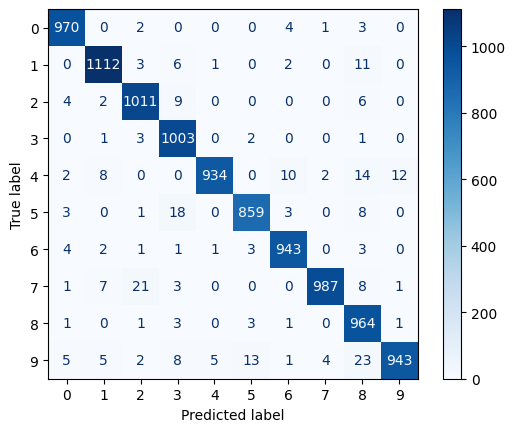

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot(cmap=plt.cm.Blues)
plt.show()